# Agent environment with bitflipping actions, using DQN with HER

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{n^2}$ vector of the $Q$-values
    * The first index corresponds to integer $\geq 0$ representing the index of the bit being flipped
    * The second index corresponds to the goal
    * So $\text{model}(s)[a][g]$ will be the $Q$-value
 * Architecture: Simple MLP

## Goals
Here, the goal determines the reward function $R_g(s, a) = R(s, a, g)$. In our case, the goals are integer $0 \leq g \leq n-1$, where $S_g = \{s \in S| d_\text{taxicab}(s, t) \leq g\}$
$$
R_g(s, a) = \begin{cases}
1 & \text{If }s \in S_g^c \rightarrow s' \in S_g \\
-1 & \text{If }s \in S_g \rightarrow s' \in S_g^c \\
0 & \text{Otherwise}
\end{cases}
$$
where $s',t$ are the new state (new bit sequence), target state (target bit sequence) respectively. Note that when $g=0$ it reduces to our usual reward function.

## Training method
DQN with HER (OpenAI paper)
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent), and a set of goals (of size 10) drawn uniformly for each agent. The agent will take action according to the first goal, and the rewards for the other randomly sampled goal(s) will be recorded. The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). We also fix the agent to use goal $g=0$. Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.


## Notes
**Optimal agent** For an optimal agent, $E[\text{steps}] = \frac{1}{2^n}\sum_{k=0}^n \dbinom{n}{k}k = \frac{n}{2}$. We expect the average number of steps to be close to $\frac{n}{2}$ if an optimal agent is chosen.

**Non-HER goal based agent** When HER is not used, we only record the experience for the agent according to the goal the agent is executing. This corresponds to num_goals=1 (do not record extra goals).

In [1]:
from src.environments.env_bit_sequence_flipping_goals import FlippingBitSequenceEnvWithGoals
from src.agents.agent_dqn_her import DQNHERAgent
from src.models.model_dqn_bitflipping_goals import BitFlippingDQNNetworkGoals, BitFlippingDQNNetworkGoalsUVFA
from src.models.buffer_bitflipping_goals import BufferBitflippingGoals
from src.models.buffer_bitflipping_goals_multirew import BufferBitflippingGoalsMultiREW
from src.utils import sample_uniform

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0")

def train_DQN_HER_agent(n: int, device: torch.device,
    episodes: int=10000, num_explore_agents: int=16, num_valid_agents: int=1024,
    num_goals: int=10, batch_size: int=2048,
    logging_frequency: int=200,
    input_goal: bool=False) -> None:

    # initialize environment, model and agent
    env = FlippingBitSequenceEnvWithGoals(n, device, fix_original_state=True)
    model = BitFlippingDQNNetworkGoals(n)
    model.to(device)
    running_model = BitFlippingDQNNetworkGoals(n)
    running_model.to(device)
    #buffer = BufferBitflippingGoals(n, no_repeat=True, device=device, max_buffer_size=2**15)
    buffer = BufferBitflippingGoalsMultiREW(n, no_repeat=True, device=device, max_buffer_size=2 ** 15)
    agent = DQNHERAgent(model=model, running_model=running_model,
                        buffer=buffer, device=device,
                    action_space_size=n, goal_space_size=n)
    
    target_value = n / 2 if not env.fix_original_state else env.get_initial_distance()

    success_rates = []
    steps_to_success = []
    loss_values = []
    mean_rewards = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)
        # uniformly and randomly choose goals for the agent to act upon
        #goals = torch.tensor(np.random.randint(0, n, (num_explore_agents, num_goals)), device=device, dtype=torch.int64)
        #goals = torch.zeros((num_explore_agents, num_goals), device=device, dtype=torch.int64)
        #goals = torch.tensor(np.random.choice(n, (1, num_goals), replace=False), device=device, dtype=torch.int64).expand(num_explore_agents, num_goals)
        
        # goals = torch.tensor(np.random.choice(n, (num_explore_agents,), replace=False), device=device, dtype=torch.int64)
        #goals = torch.zeros((num_explore_agents,), device=device, dtype=torch.int64)
        goals = torch.tensor(sample_uniform(n, num_explore_agents), device=device, dtype=torch.int64)

        # let agent act for at most 2 * n steps
        for _ in range(2 * n):  # max time stepss
            with torch.no_grad():
                action = agent.act(state, explore=True, goal=goals) # act with the randomly picked first goal for that agent
                next_state, reward, done, info = env.step(action,
                                    goals=torch.arange(n, dtype=torch.long, device=device).unsqueeze(0).expand(num_explore_agents, n))
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                goal_rewards = info["goal_rewards"] # tensor indicating the reward for each goal
                prev_step_ongoing = ~prev_done



                # record transitions in replay buffer
                if prev_step_ongoing.sum() == 0:
                    pass
                elif isinstance(buffer, BufferBitflippingGoalsMultiREW):
                    agent.remember(state[prev_step_ongoing, :].cpu().numpy(),
                                    action[prev_step_ongoing].cpu().numpy(),
                                    goal_rewards[prev_step_ongoing, :].cpu().numpy(),
                                    next_state[prev_step_ongoing, :].cpu().numpy(),
                                    done[prev_step_ongoing].cpu().numpy(),
                                    None) # record the rewards for all goals (HER)
                else:
                    agent.remember(np.tile(state[prev_step_ongoing, :].cpu().numpy(), reps=(num_goals, 1)),
                                    np.tile(action[prev_step_ongoing].cpu().numpy(), reps=(num_goals,)),
                                    np.concatenate([goal_rewards[prev_step_ongoing, goal_idx].cpu().numpy() for goal_idx in range(num_goals)], axis=0),
                                    np.tile(next_state[prev_step_ongoing, :].cpu().numpy(), reps=(num_goals, 1)),
                                    np.tile(done[prev_step_ongoing].cpu().numpy(), reps=(num_goals,)),
                                    np.concatenate([goals[prev_step_ongoing, goal_idx].cpu().numpy() for goal_idx in range(num_goals)], axis=0)) # record the goal specific rewards (HER)
                state = next_state
                if done.all():
                    break
        
        # replay to update Q network
        loss = agent.replay(batch_size=batch_size, opt_steps=1)

        # now run the agent for at most 2 * n steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for step in range(2 * n):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False, goal=0)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                if step == 0: # if by random chance the agent is already done in the first step, we need to handle this case
                    agent_steps_to_success[prev_done.cpu().numpy()] = 0
                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        mean_reward = buffer.get_avg_reward()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)
        loss_values.append(loss)
        mean_rewards.append(mean_reward)

        if e > 100 and (np.array(steps_to_success[-100:]) < target_value + 1).all():
            print("Early stopping at episode", e)
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
            break

        if (e + 1) % logging_frequency == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(24, 16))
    plt.subplot(2, 3, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(2, 3, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.subplot(2, 3, 3)
    plt.plot(steps_to_success)
    plt.ylim(target_value - 1, target_value + 1)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes (Zoom)")
    plt.subplot(2, 3, 4)
    plt.plot(loss_values)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes")
    plt.subplot(2, 3, 5)
    plt.plot(loss_values)
    plt.ylim(0.0, 0.01)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes (Zoom)")
    plt.subplot(2, 3, 6)
    plt.plot(mean_rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Mean reward in buffer")
    plt.title("Mean reward in buffer over episodes")
    plt.show()

    return env, agent

def visualize_agent_trajectory(env: FlippingBitSequenceEnvWithGoals, agent: DQNHERAgent,
                               n: int, explore: bool=True, explore_mode: str="logits_temperature",
                               num_agents: int=16, goal: int=0,
                               steps: int=2 * 16) -> None:
    assert isinstance(goal, int), "Goal must be an integer"
    assert 0 <= goal < n, "Invalid goal"

    distances = []

    state = env.reset(num_agents=num_agents)
    for _ in range(steps):  # max time steps
        with torch.no_grad():
            action = agent.act(state, explore=explore, explore_mode=explore_mode, goal=goal) # act with the randomly picked first goal for that agent
            next_state, reward, done, info = env.step(action)
            prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
            distance = info["distance"] # tensor indicating the distance to the target

            distances.append(distance.cpu().numpy())

            state = next_state
            if done.all():
                break
    
    distances = np.stack(distances, axis=0)

    # plot distances in the same graph
    plt.figure(figsize=(24, 16))
    plt.plot(distances)
    plt.xlabel("Steps")
    plt.ylabel("Distance to target")
    plt.title("Distance to target over steps")
    plt.show()

# Experiments (With HER)

$n=2$, optimal agent achieved as steps $\sim 1$

Initialized FlippingBitSequenceEnvWithGoals with n = 2. Randomly picked target: tensor([1, 0], device='cuda:0')
Initial distance to target: 1
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 103/10000 [00:01<01:51, 88.78it/s] 


Early stopping at episode 103
Episode: 103/10000, Epsilon: 0.9011784036598737, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.000006


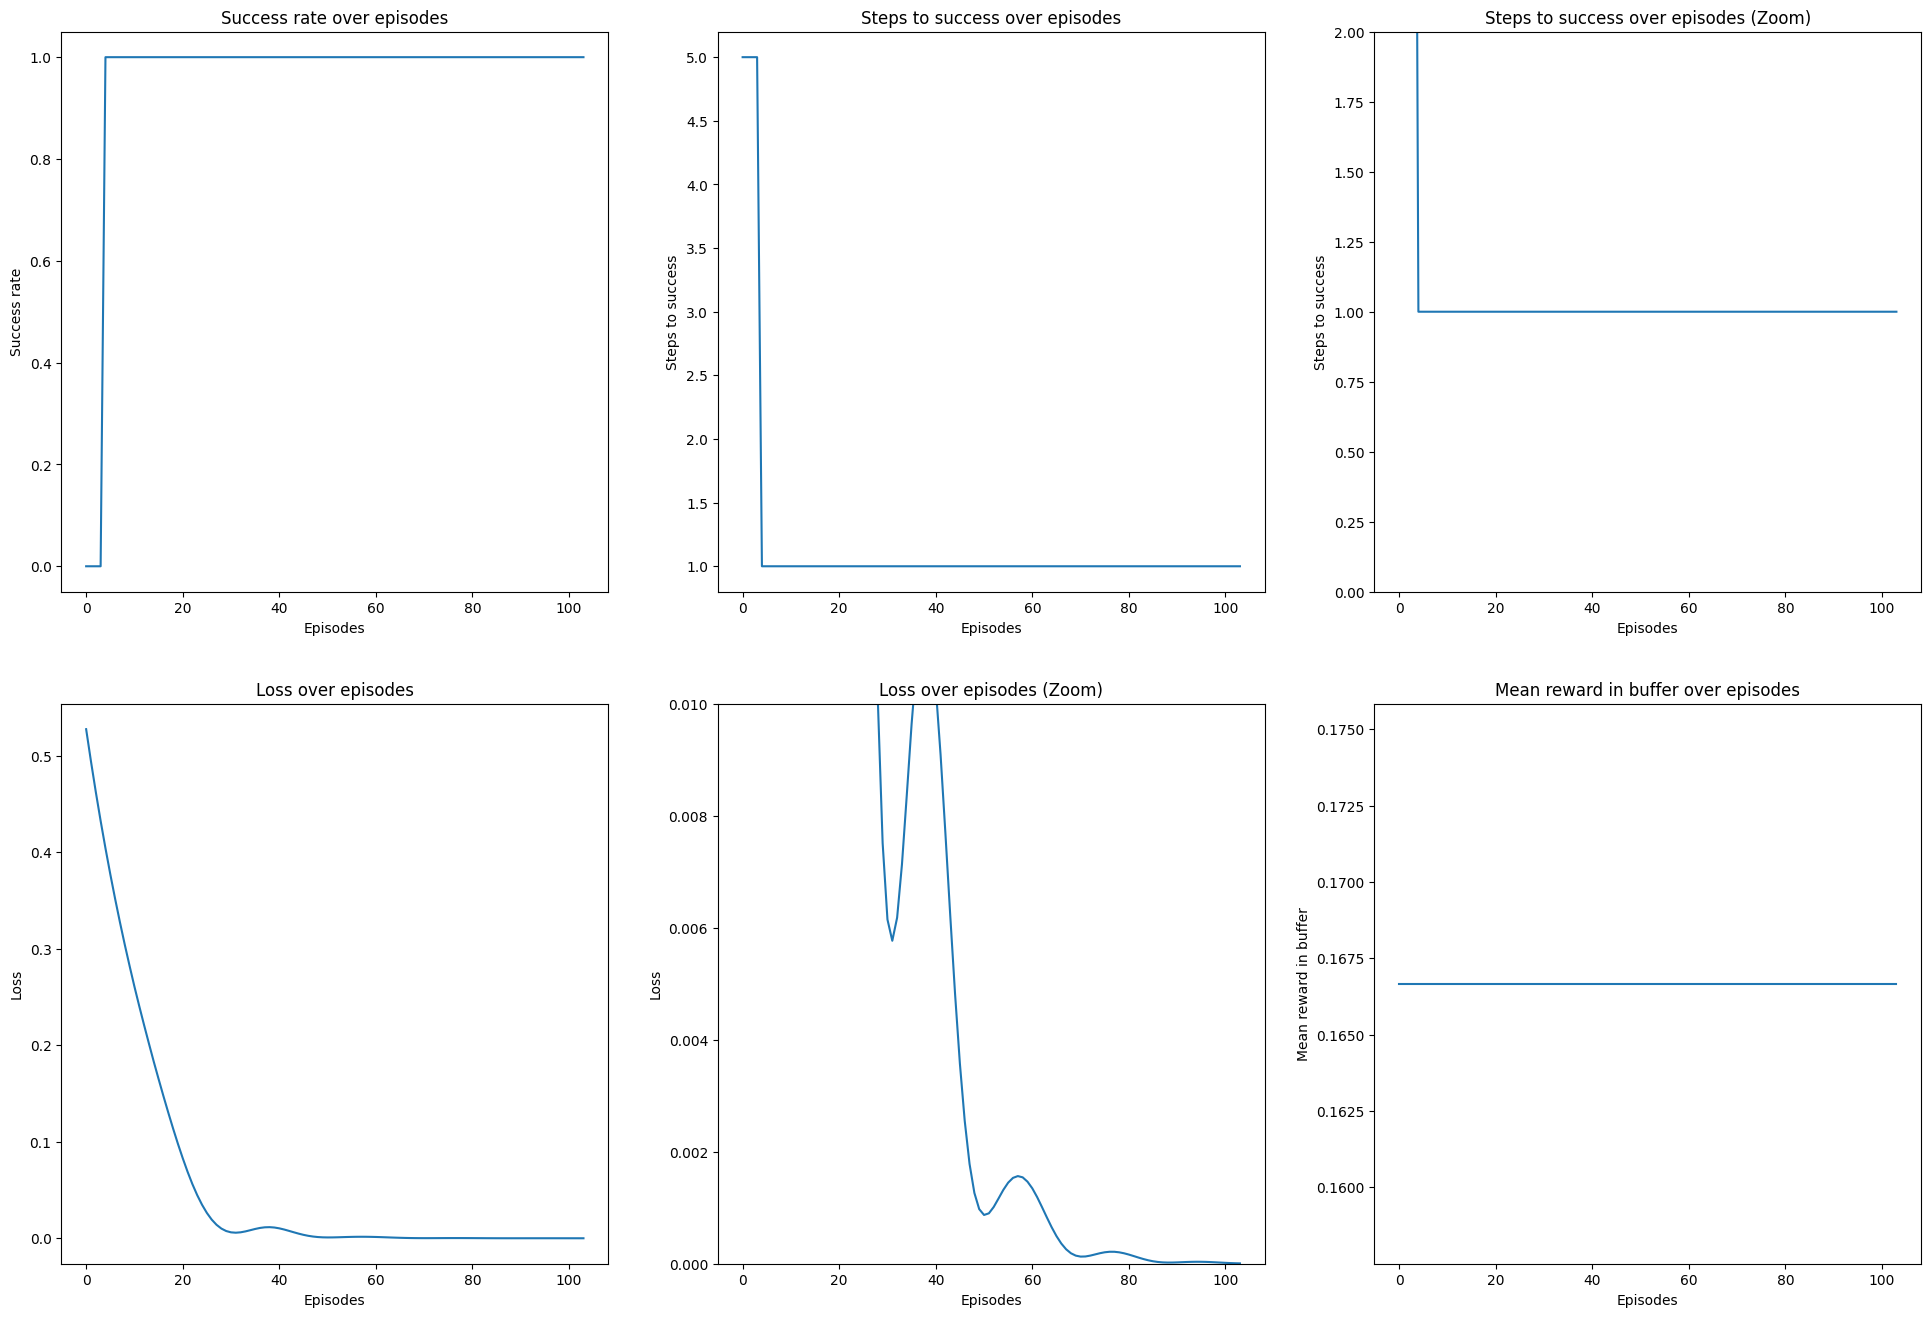

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7835cc7ef6d0>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7835cc7eec20>)

In [2]:
train_DQN_HER_agent(2, device=device)

$n=3$, optimal agent achieved as steps $\sim \frac{3}{2}$

Initialized FlippingBitSequenceEnvWithGoals with n = 3. Randomly picked target: tensor([0, 0, 1], device='cuda:0')
Initial distance to target: 1
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 101/10000 [00:01<02:03, 79.96it/s] 


Early stopping at episode 101
Episode: 101/10000, Epsilon: 0.9029834676116293, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.001219


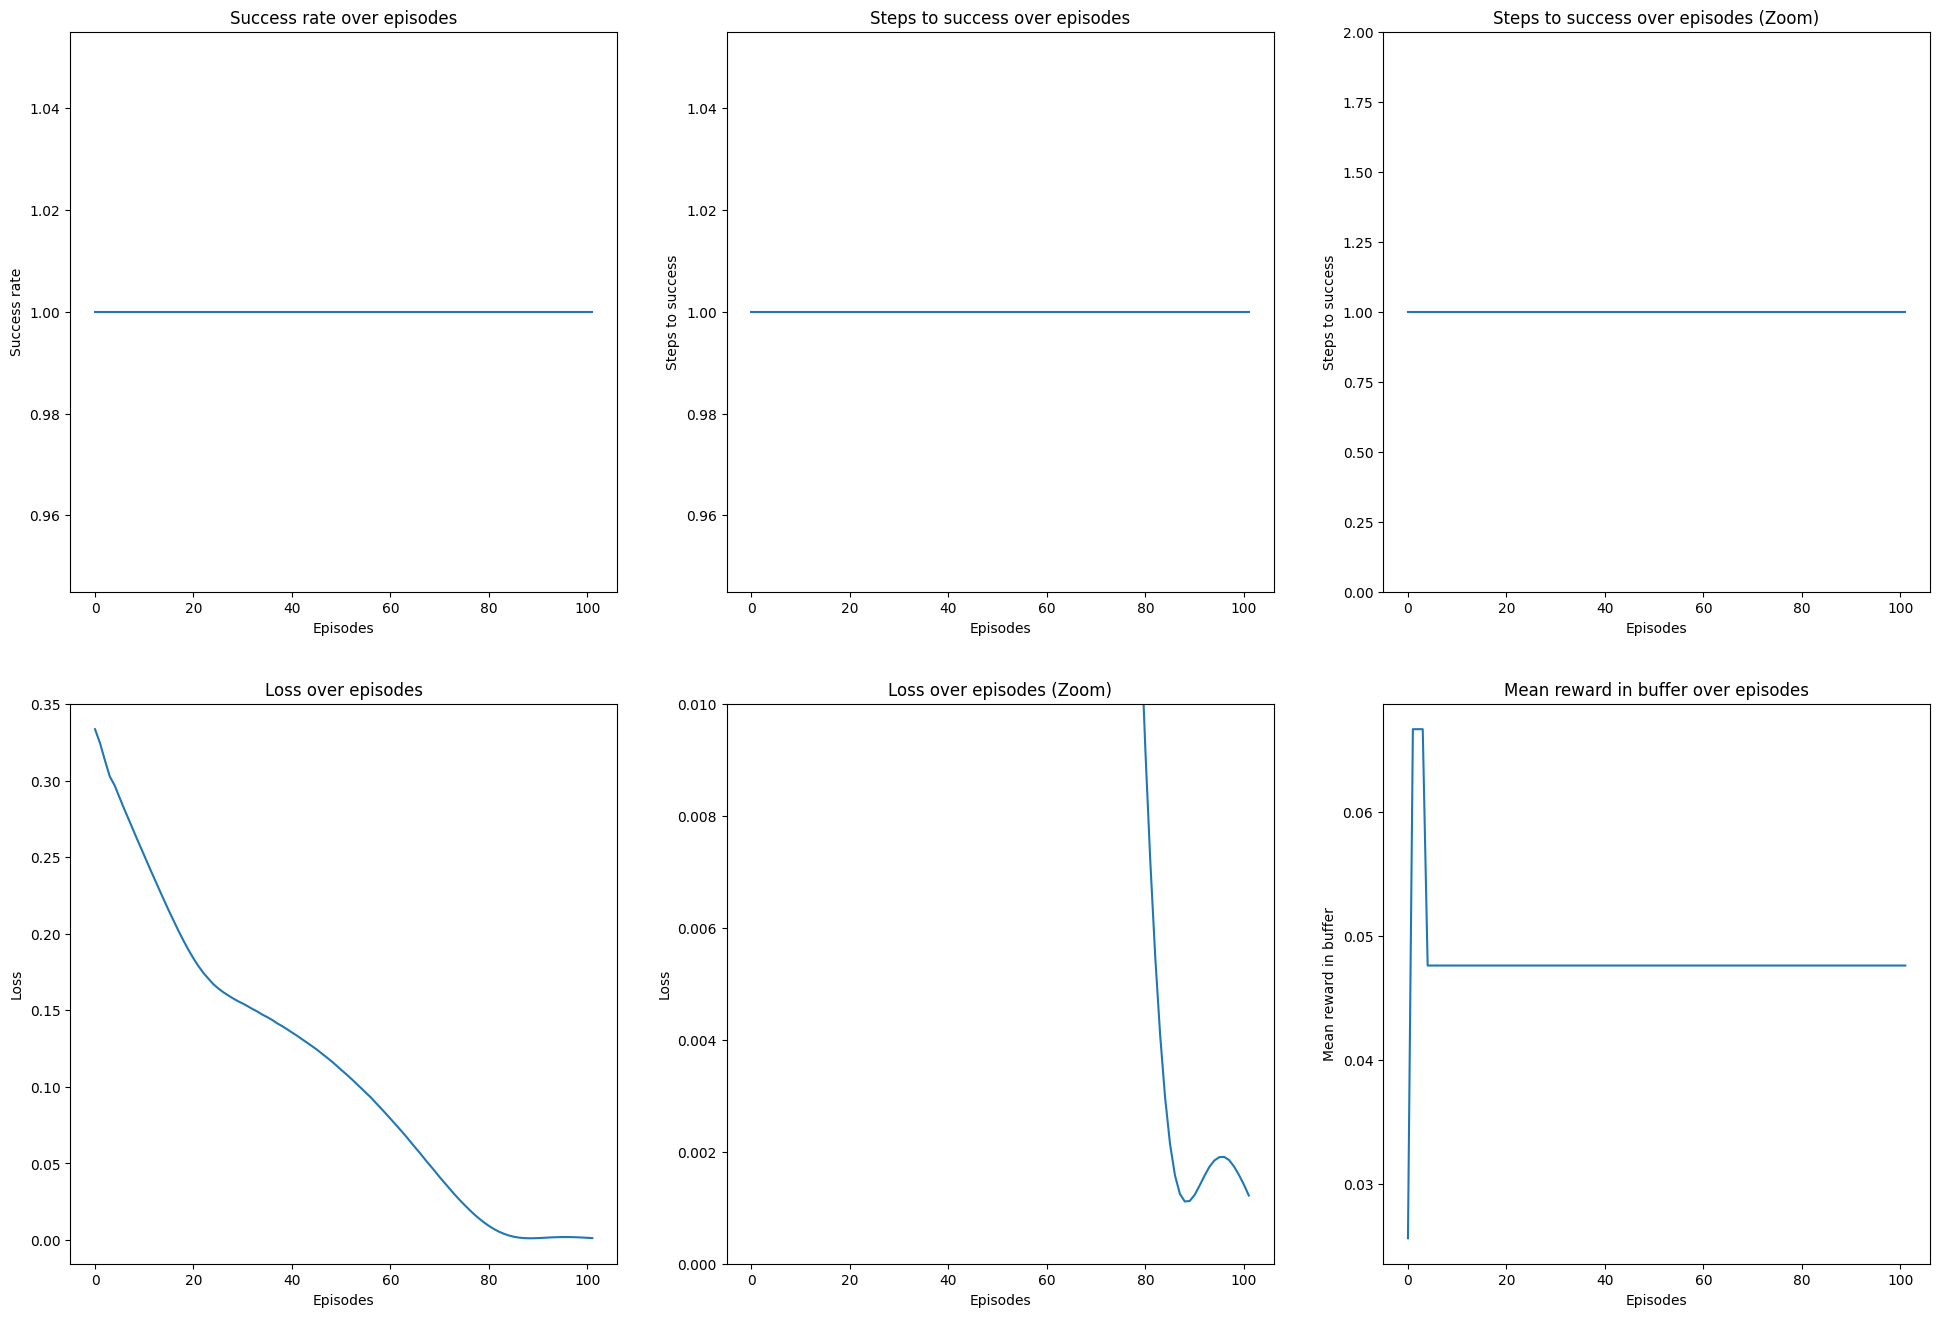

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x78359e9fafe0>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7835cc7efeb0>)

In [3]:
train_DQN_HER_agent(3, device=device)

$n=6$, optimal agent achieved as steps $\sim 3$

Initialized FlippingBitSequenceEnvWithGoals with n = 6. Randomly picked target: tensor([1, 0, 1, 0, 0, 0], device='cuda:0')
Initial distance to target: 2
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|▏         | 139/10000 [00:03<03:37, 45.39it/s]


Early stopping at episode 139
Episode: 139/10000, Epsilon: 0.8692973418545467, Success rate: 1.00, Avg steps to success: 2.00, Loss: 0.085037


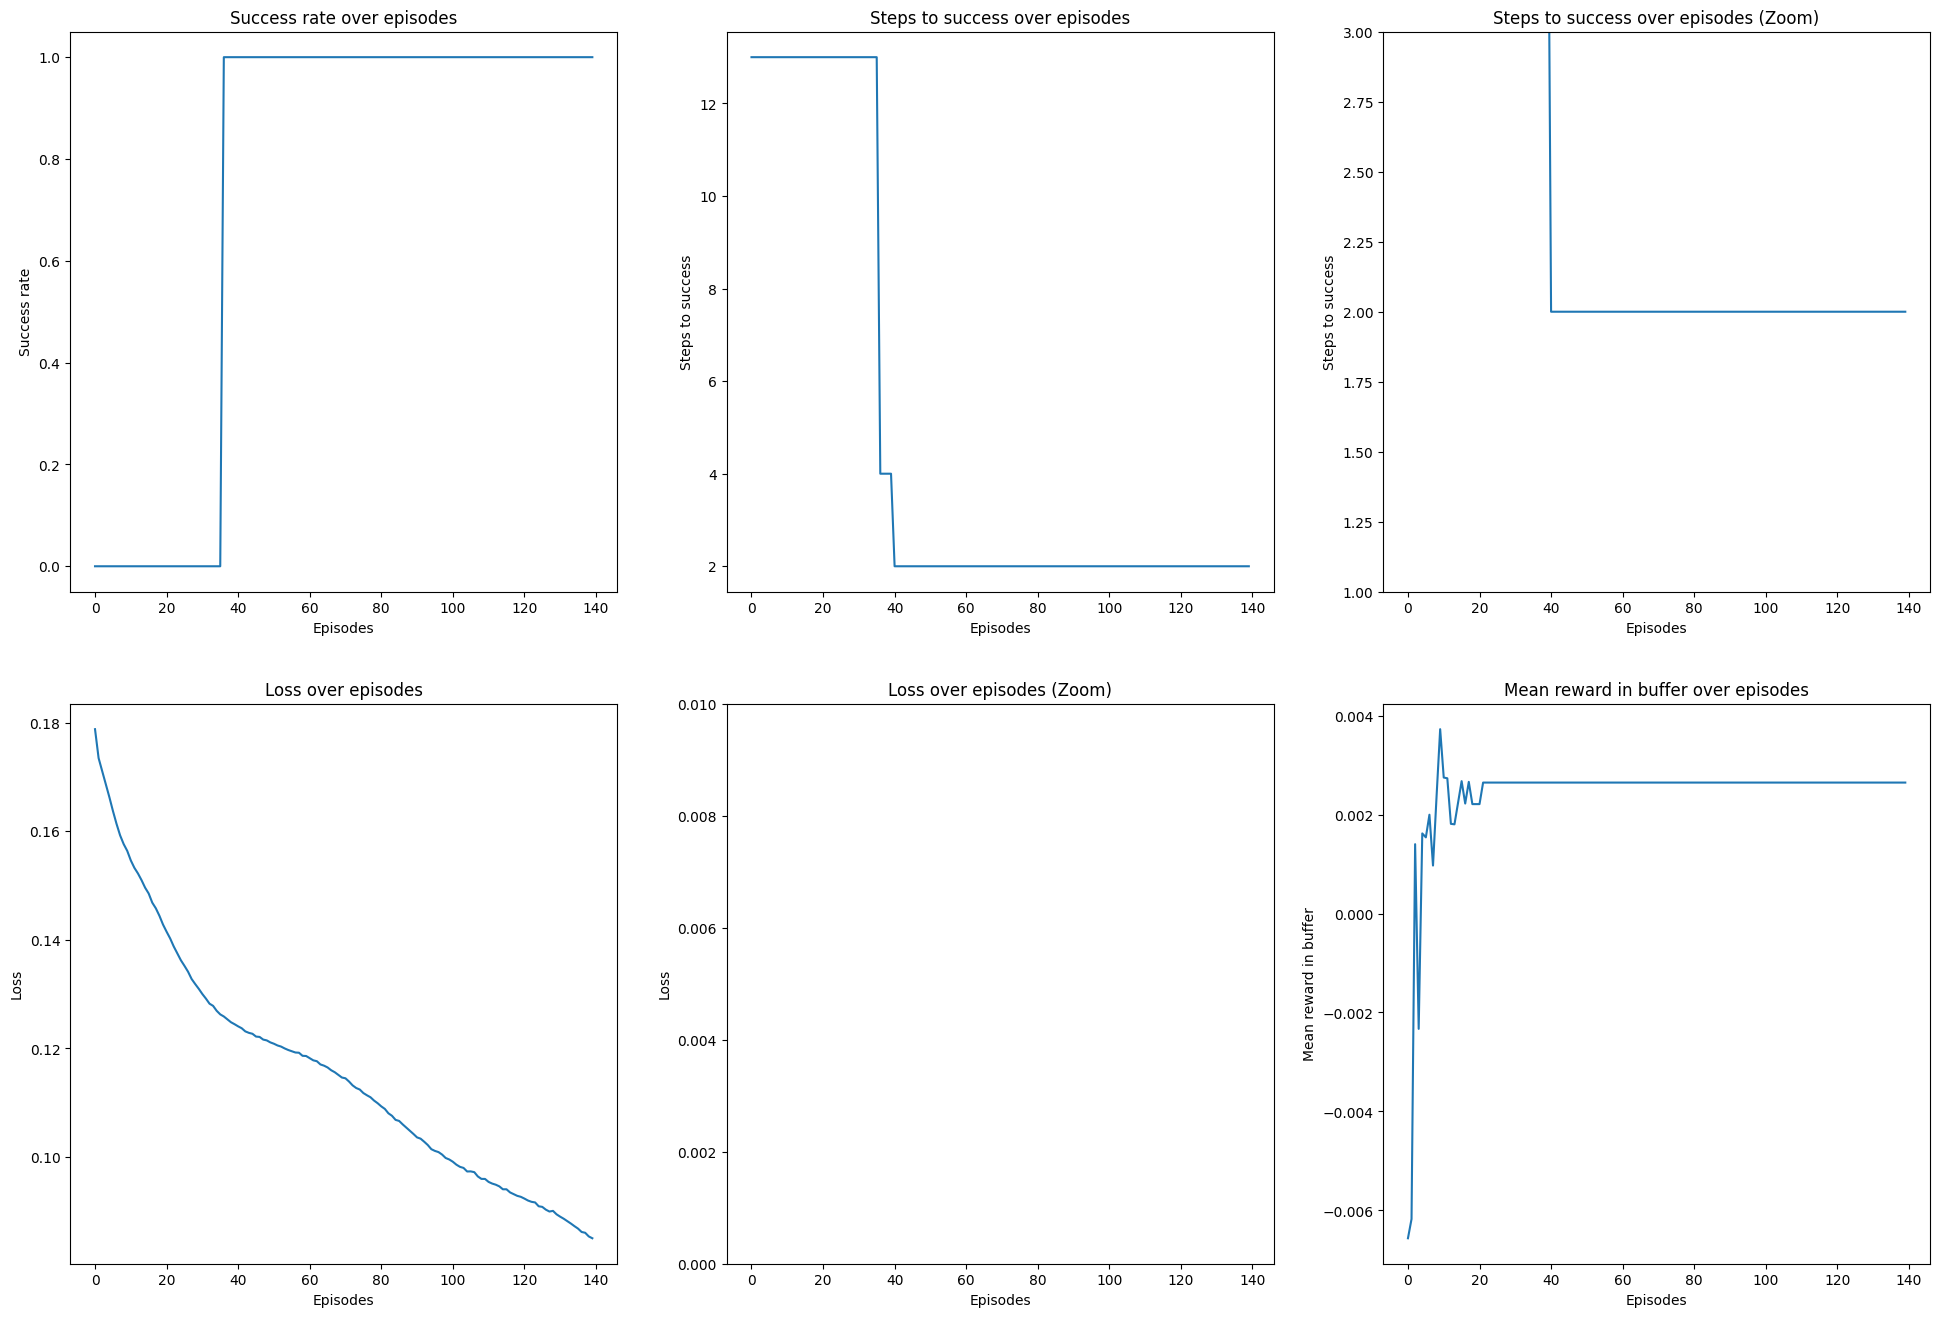

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7835a11c0cd0>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7835cc766260>)

In [4]:
train_DQN_HER_agent(6, device=device)

$n=15$, optimal agent achieved as steps $\sim 7.5$

Initialized FlippingBitSequenceEnvWithGoals with n = 9. Randomly picked target: tensor([1, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Initial distance to target: 6
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 205/10000 [00:07<05:00, 32.55it/s]

Episode: 199/10000, Epsilon: 0.818648829478636, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.069408


  4%|▍         | 405/10000 [00:13<04:57, 32.24it/s]

Episode: 399/10000, Epsilon: 0.6701859060067403, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.020918


  6%|▌         | 605/10000 [00:19<04:37, 33.83it/s]

Episode: 599/10000, Epsilon: 0.5486469074854965, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.008572


  8%|▊         | 805/10000 [00:25<04:42, 32.59it/s]

Episode: 799/10000, Epsilon: 0.4491491486100748, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.004688


 10%|█         | 1006/10000 [00:31<04:03, 36.96it/s]

Episode: 999/10000, Epsilon: 0.3676954247709635, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.004070


 12%|█▏        | 1207/10000 [00:36<03:51, 37.92it/s]

Episode: 1199/10000, Epsilon: 0.3010134290933992, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.003000


 14%|█▍        | 1407/10000 [00:42<03:52, 36.93it/s]

Episode: 1399/10000, Epsilon: 0.24642429138466176, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.002555


 16%|█▌        | 1605/10000 [00:47<03:42, 37.77it/s]

Episode: 1599/10000, Epsilon: 0.20173495769715546, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.001898


 18%|█▊        | 1805/10000 [00:52<04:11, 32.54it/s]

Episode: 1799/10000, Epsilon: 0.1651500869836984, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.001676


 20%|██        | 2007/10000 [00:58<03:43, 35.74it/s]

Episode: 1999/10000, Epsilon: 0.1351999253974994, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.001390


 22%|██▏       | 2204/10000 [01:03<04:03, 32.03it/s]

Episode: 2199/10000, Epsilon: 0.11068126067226178, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.001416


 24%|██▍       | 2407/10000 [01:09<03:28, 36.50it/s]

Episode: 2399/10000, Epsilon: 0.09060908449456685, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.001302


 26%|██▌       | 2604/10000 [01:15<03:39, 33.73it/s]

Episode: 2599/10000, Epsilon: 0.07417702096160789, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.001026


 28%|██▊       | 2804/10000 [01:21<03:36, 33.18it/s]

Episode: 2799/10000, Epsilon: 0.06072493138443261, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000987


 30%|███       | 3004/10000 [01:27<03:29, 33.42it/s]

Episode: 2999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000795


 32%|███▏      | 3204/10000 [01:33<03:33, 31.90it/s]

Episode: 3199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000719


 34%|███▍      | 3404/10000 [01:39<03:24, 32.24it/s]

Episode: 3399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000820


 36%|███▌      | 3604/10000 [01:45<02:56, 36.23it/s]

Episode: 3599/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.000865


 38%|███▊      | 3804/10000 [01:51<02:58, 34.63it/s]

Episode: 3799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000744


 40%|████      | 4004/10000 [01:57<02:57, 33.69it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000649


 42%|████▏     | 4204/10000 [02:03<02:59, 32.31it/s]

Episode: 4199/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 8.00, Loss: 0.000666


 44%|████▍     | 4404/10000 [02:09<02:40, 34.86it/s]

Episode: 4399/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000646


 46%|████▌     | 4604/10000 [02:15<02:40, 33.66it/s]

Episode: 4599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000810


 48%|████▊     | 4804/10000 [02:21<02:39, 32.55it/s]

Episode: 4799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000772


 50%|█████     | 5004/10000 [02:27<02:29, 33.44it/s]

Episode: 4999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000568


 52%|█████▏    | 5204/10000 [02:33<02:20, 34.16it/s]

Episode: 5199/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000500


 54%|█████▍    | 5404/10000 [02:39<02:23, 31.96it/s]

Episode: 5399/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000607


 56%|█████▌    | 5604/10000 [02:45<02:19, 31.50it/s]

Episode: 5599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000512


 58%|█████▊    | 5804/10000 [02:51<02:12, 31.62it/s]

Episode: 5799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000658


 60%|██████    | 6004/10000 [02:57<02:01, 32.87it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000539


 62%|██████▏   | 6204/10000 [03:03<01:54, 33.06it/s]

Episode: 6199/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000527


 64%|██████▍   | 6404/10000 [03:10<01:53, 31.69it/s]

Episode: 6399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000543


 66%|██████▌   | 6604/10000 [03:16<01:38, 34.41it/s]

Episode: 6599/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000540


 68%|██████▊   | 6804/10000 [03:22<01:37, 32.65it/s]

Episode: 6799/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000525


 70%|███████   | 7004/10000 [03:28<01:36, 31.16it/s]

Episode: 6999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000465


 72%|███████▏  | 7205/10000 [03:34<01:19, 35.33it/s]

Episode: 7199/10000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 6.00, Loss: 0.000510


 74%|███████▍  | 7405/10000 [03:40<01:22, 31.32it/s]

Episode: 7399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000501


 76%|███████▌  | 7605/10000 [03:47<01:13, 32.74it/s]

Episode: 7599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000428


 78%|███████▊  | 7805/10000 [03:53<01:07, 32.29it/s]

Episode: 7799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000433


 80%|████████  | 8005/10000 [03:59<01:01, 32.46it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000332


 82%|████████▏ | 8205/10000 [04:05<00:54, 32.76it/s]

Episode: 8199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000429


 84%|████████▍ | 8405/10000 [04:11<00:46, 34.11it/s]

Episode: 8399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000430


 86%|████████▌ | 8605/10000 [04:17<00:41, 33.52it/s]

Episode: 8599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000368


 88%|████████▊ | 8805/10000 [04:23<00:35, 33.79it/s]

Episode: 8799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000348


 90%|█████████ | 9005/10000 [04:29<00:31, 31.19it/s]

Episode: 8999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000372


 92%|█████████▏| 9205/10000 [04:36<00:25, 31.32it/s]

Episode: 9199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000431


 94%|█████████▍| 9405/10000 [04:42<00:19, 30.88it/s]

Episode: 9399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000304


 96%|█████████▌| 9605/10000 [04:48<00:13, 30.00it/s]

Episode: 9599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000342


 98%|█████████▊| 9805/10000 [04:54<00:05, 32.88it/s]

Episode: 9799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000385


100%|██████████| 10000/10000 [05:00<00:00, 33.25it/s]


Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.000330


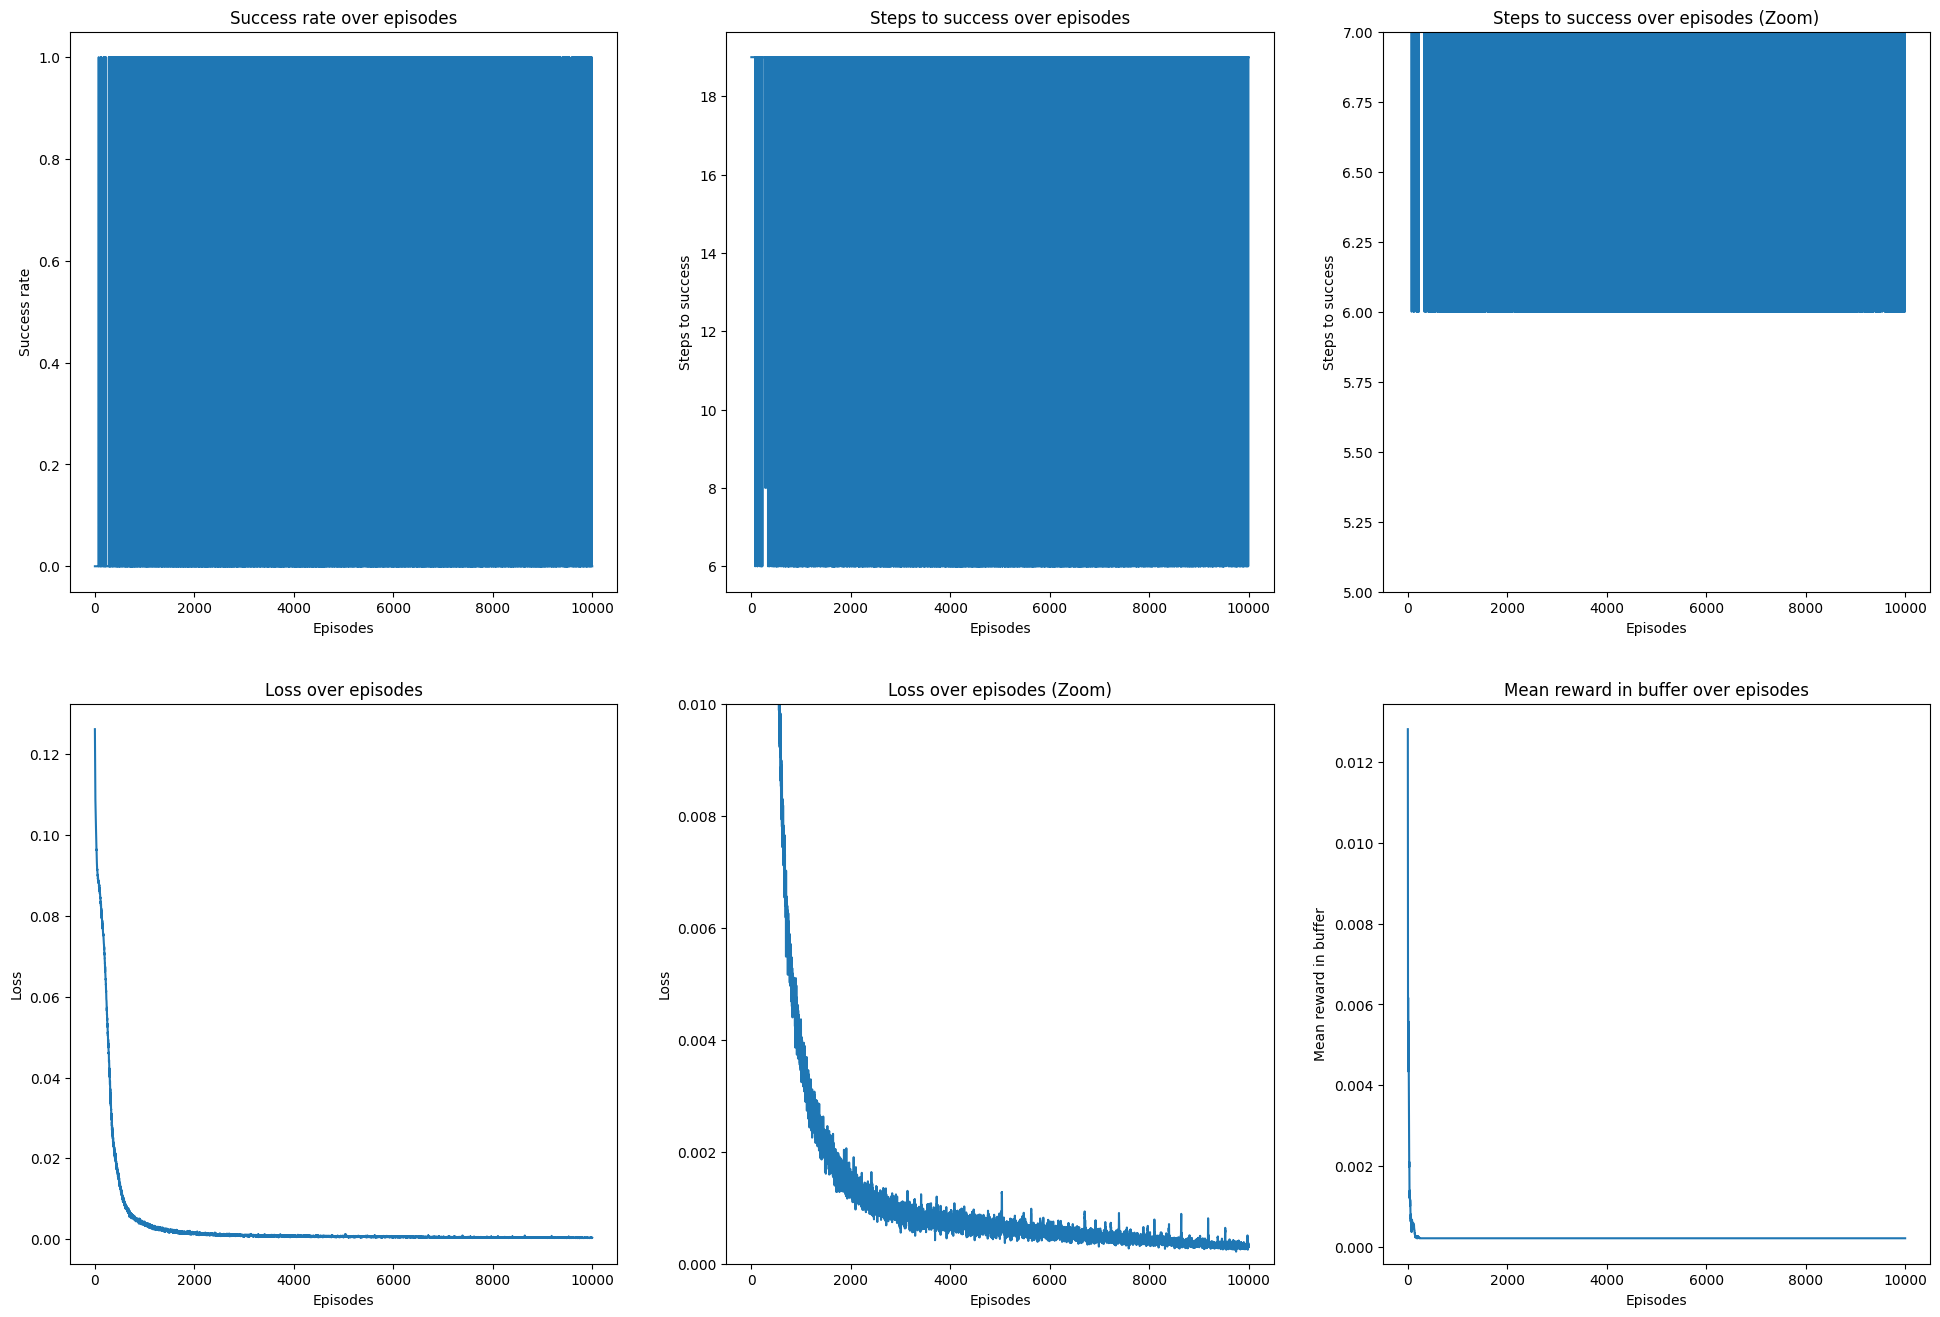

In [5]:
env, agent = train_DQN_HER_agent(9, device=device, num_goals=30)

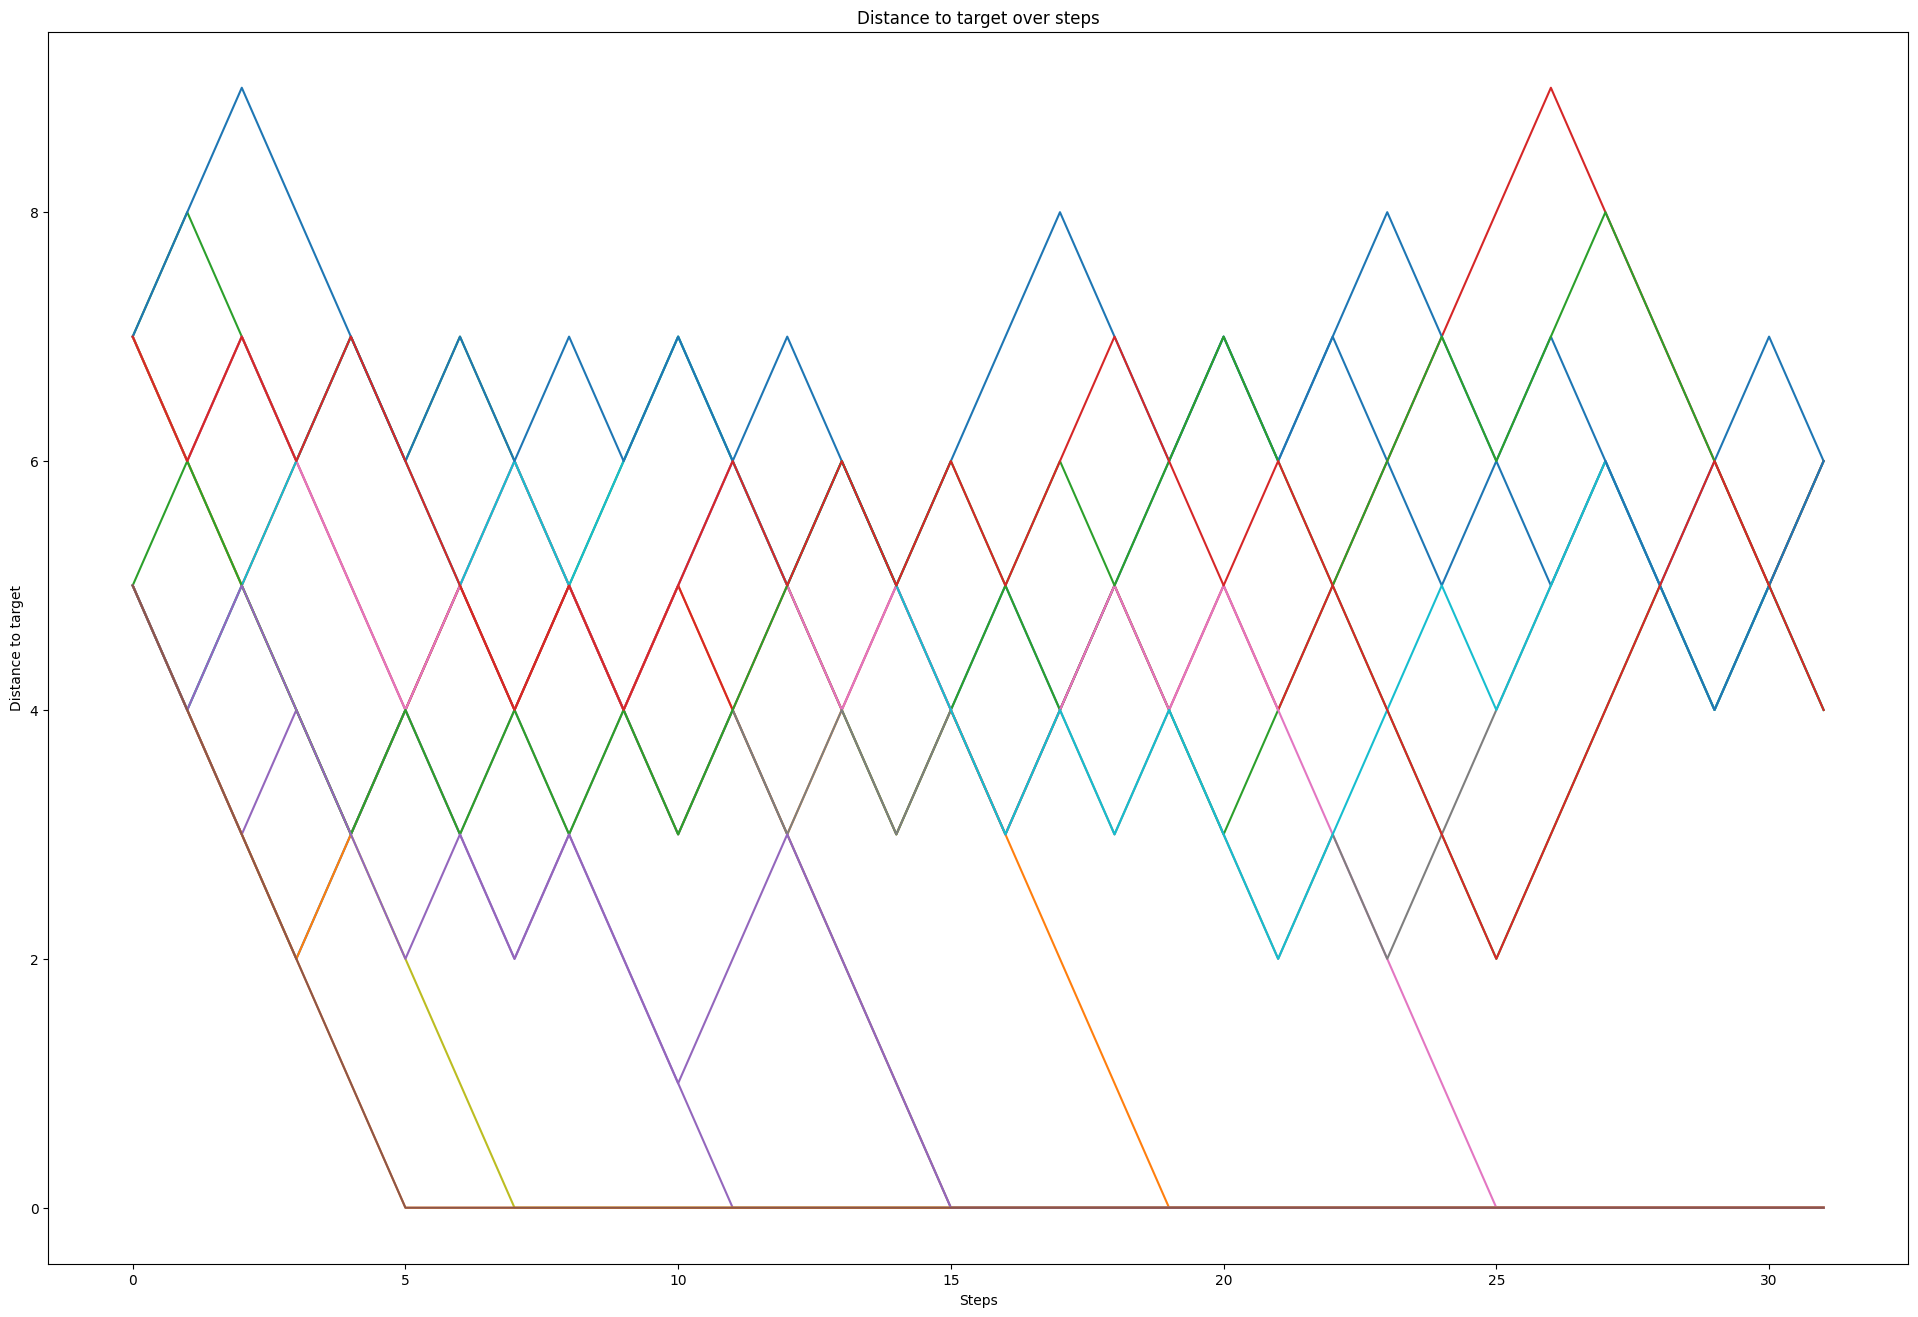

In [6]:
visualize_agent_trajectory(env, agent, 9, explore=True, explore_mode="logits_temperature", num_agents=16, goal=0, steps=2 * 16)

$n=15$. Given more training epochs, an optimal agent could be found (avg steps 7.5)

In [7]:
env, agent = train_DQN_HER_agent(15, device=device, episodes=10000)

Initialized FlippingBitSequenceEnvWithGoals with n = 15. Randomly picked target: tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Initial distance to target: 9
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 201/10000 [00:14<11:12, 14.57it/s]

Episode: 199/10000, Epsilon: 0.818648829478636, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


  2%|▏         | 239/10000 [00:17<11:07, 14.63it/s]

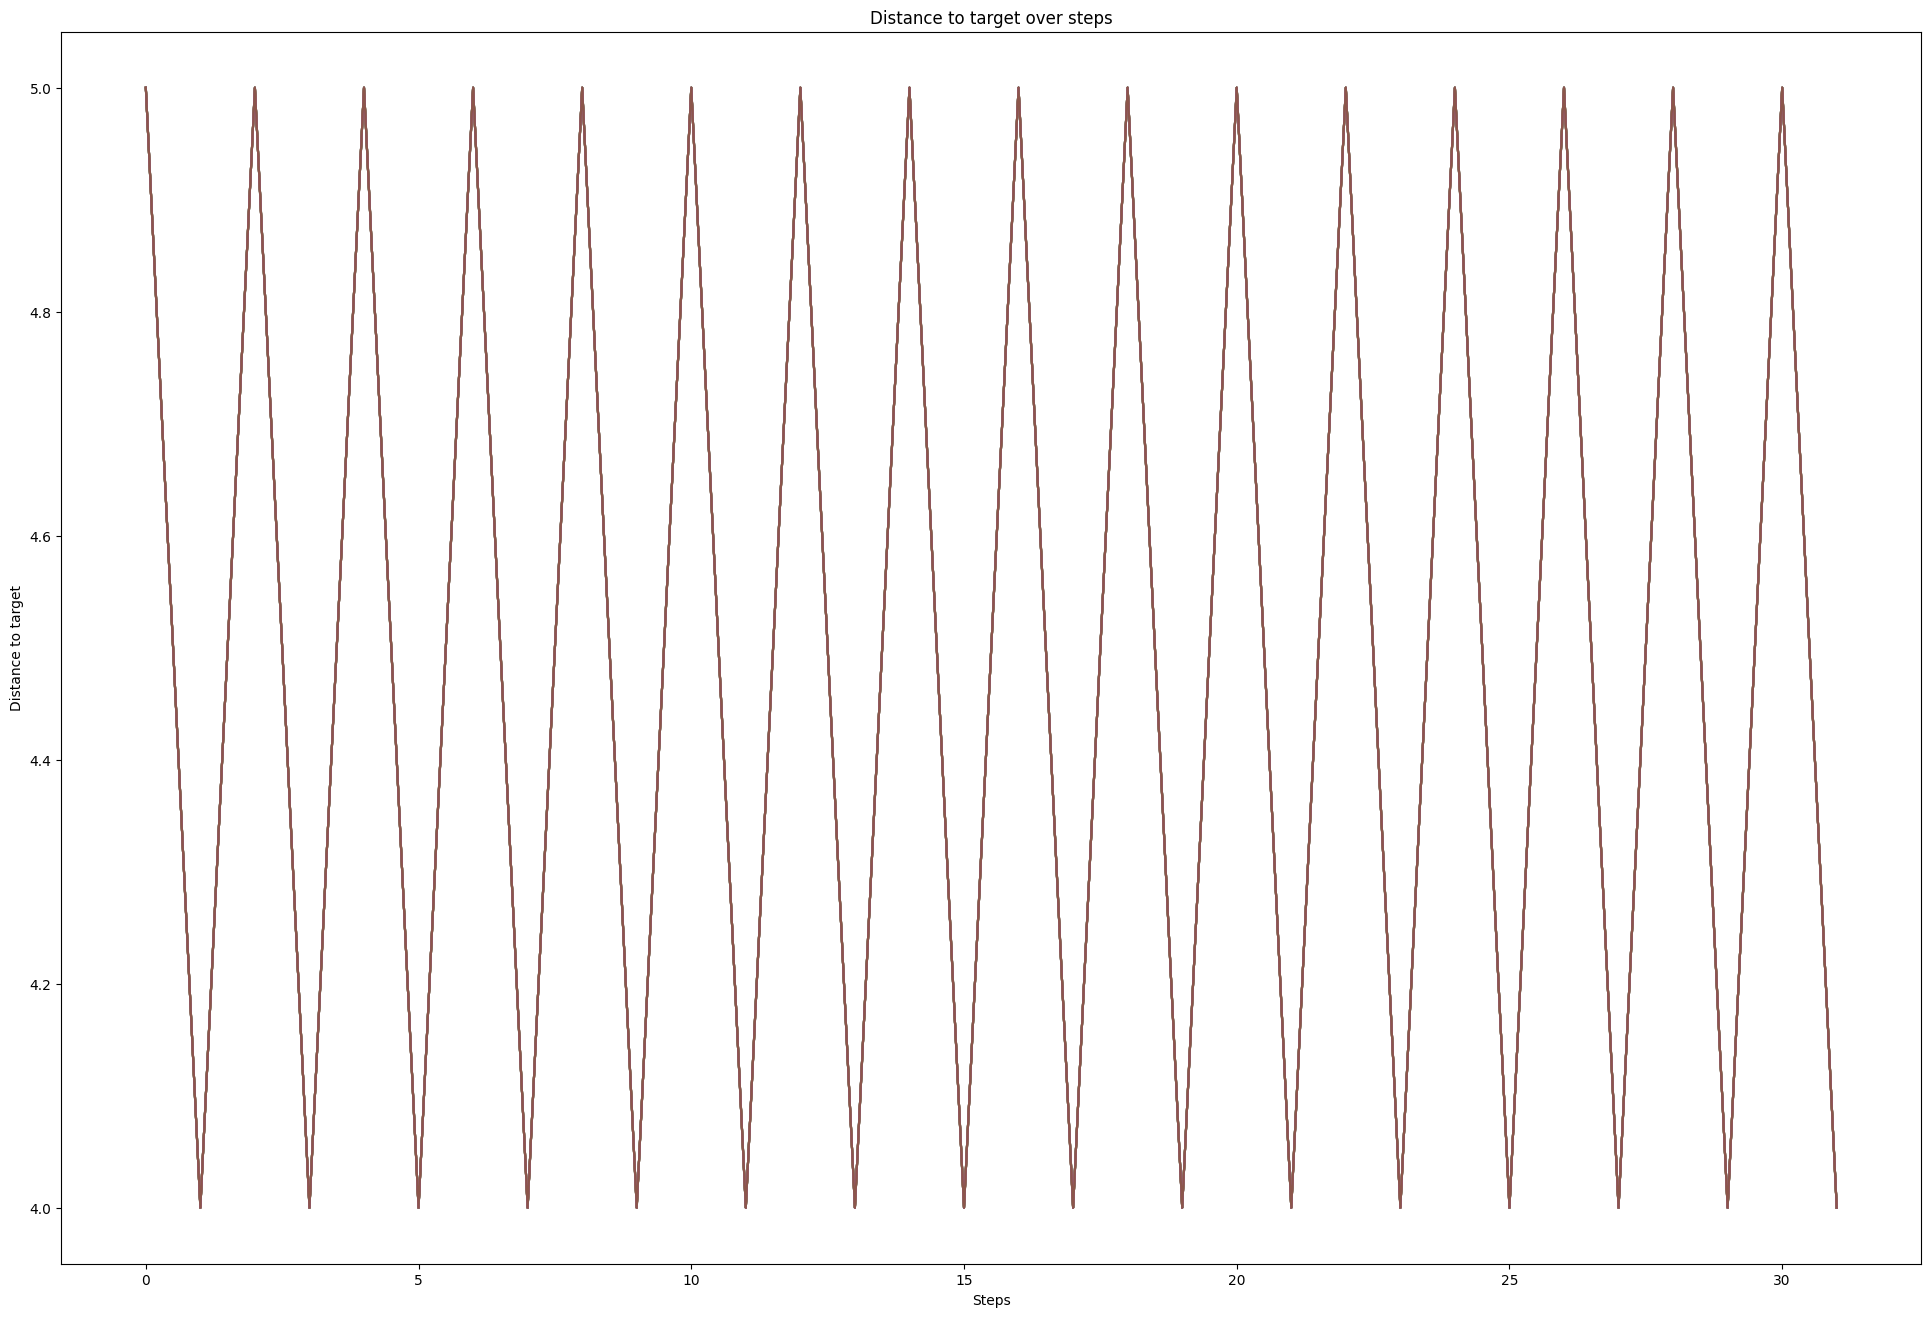

In [ ]:
visualize_agent_trajectory(env, agent, 15, explore=False, explore_mode="logits_temperature", num_agents=16, goal=5, steps=2 * 16)

$n=30$ Now, with HER, our agent is able to find the optimal policy!

In [ ]:
train_DQN_HER_agent(30, device=device, episodes=10000, logging_frequency=2000)

Initialized FlippingBitSequenceEnvWithGoals with n = 30. Randomly picked target: tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0], device='cuda:0')
Initial distance to target: 17
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 20%|██        | 2001/10000 [06:00<24:08,  5.52it/s]

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000001


 40%|████      | 4001/10000 [11:58<17:58,  5.56it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 48%|████▊     | 4812/10000 [14:21<15:35,  5.54it/s]

$n=50$ Testing large $n$ with HER.

In [ ]:
train_DQN_HER_agent(50, device=device, episodes=10000, logging_frequency=2000)

# Experiements (DQN with goals, but no HER)

Here we only record the rewards of the goals where the exploration agent has acted with (meaning no HER). As mentioned before, this corresponds to $\text{num\_goals} = 1$

In [ ]:
train_DQN_HER_agent(30, device=device, episodes=10000, logging_frequency=2000)

In [ ]:
train_DQN_HER_agent(50, device=device, episodes=10000, logging_frequency=2000)